In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.interpolate
import scipy.linalg as la
import pylab as pl
import math
from scipy import stats
from scipy.stats import multivariate_normal, probplot
from sklearn import preprocessing
import statsmodels.api as sm
import pickle

import scipy as SP
import scipy.optimize as opt
import pylab
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# import helper functions from starter code
from gwas import *

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# GWAS problem - Introduction

**Overall goal**: This real world problem is one in computational biology which uses many of the techniques and concepts you have been introduced to, all together, in particular, linear regression, PCA, non-iid noise, diagonalizing multivariate Gaussian covariance matrices, and bias-variance trade-off. We will also tangentially introduce you to concepts of statistical testing. \textbf{This homework problem is effectively a demo in that we will ask you to execute code and answer questions about what you observe. You are not required to code anything at all.}

**Setup and problem statement:** Given a set of people for whom genetics (DNA) has been measured, and also a corresponding trait for each person, such as blood pressure, or ”is-a-smoker”, one can use data-driven methods to deduce which genetic effects are likely responsible for the trait. We have collected blood from n individuals who either smoke ($y_i = 1$) or do not smoke ($y_i = 0$). Their blood samples have been sequenced at $m$ positions along the genome, yielding the feature matrix $X \in \mathbb{R}^{n\times m}$, composed of the genetic variants (which take on values 0, 1, or 2). Specifically, $X_{i,j}$ is a numeric encoding of the DNA for the $i$th person at genetic feature $j$. We want to deduce which of the $m$ genetic features are associated with smoking, by considering one at a time. 

**In the data we give you, it will turn out that there is no true signal in the data; however, we will see that without careful modeling, we would erroneously conclude that the data was full of signal. Left unmodeled, such structure creates misleading results, yielding signal where none exists.**


**Overall modelling approach:** The basic idea will be to "test" one genetic feature at a time and assign a score (a p-value) indicating our level of belief that it is associated with the trait. We will start with a simple linear regression model, and then build increasingly more correct linear predictive models. The three models we will use are (1) linear regression, (2) linear regression with PCA features, (3) linear regression with all genetic variants as features. The first model is naive, because it assumes the individuals are iid. The fundamental modelling challenges with these kinds of analyses is that the individuals in the study are not typically not iid, owing to differences in race and family-relatedness (e.g., sisters, brothers, patients, grandparents in the data set), which violate the iid assumption. Left unmodelled, such structure creates misleading results, yielding signal where none exists. Luckily, as we shall see, one can visualize these modelling issues via quantile-quantile plots, which will soon be briefly introduced.


**Quick introduction to Hypothesis Testing**

To understand whether genetic marker $j$ is informative in predicting the the target, we will set up a hypothesis test. A Hypothesis Test allows us to examine two different "views" of the world, the Null and the Alternative, and conclude which one is more likely based on the data we observe. A Hypothesis Test has the following main components:

* **Null Hypothesis:** The genetic marker is not significant in predicting the target. Any relation you observe between the genetic marker and the target is merely due to chance.
* **Alternative Hypothesis:** The genetic marker contains important information about the target.
* **p-value:** The final result of a hypothesis test is a p-value. A p-value is a number between $[0, 1]$ which you should interpret as follows: If the p-value is really small, that is evidence against the Null and in favor of the Alternative hypothesis. If the p-value is large then this is evidence towards the Null.

**We will perform a single Hypothesis Test for each of the genetic markers that we have in our dataset. This process, will give us back $m$ p-values. These $m$ values will make up the empirical distribution of our p-values.**


**How to test each variant**
Herein we provide a minimal exposition to allow you to do the homework. To estimate how implicated each genetic feature is we will use a score, in the form of a p-value. One can think of the p-value as a proxy for how informative the genetic feature is for prediction of the trait (e.g. "is smoker"). More precisely, to get the p-value for the $j^{\text{th}}$ genetic feature, we first include it in the model (for a given model class, such as linear regression) and compute the maximum likelihood, $LL_{j}$ (this is our alternative hypothesis). Then we repeat this process, but having removed the genetic feature of interest from the model, yielding $LL_{-j}$ (this is our null hypothesis). To be clear, the null hypothesis will have none of the $m$ genetic variants that are being tested. You can refer to the jupyter notebook for a brief explanation of hypothesis testing. The p-value is then a simple monotonic decreasing function of the difference in these two likelihoods, $ \verb|diff_ll|=LL_j - LL_{-j}$--one that we will give you. P-values lie in $[0,1]$ and the smaller the p-value, the larger the difference in the likelihoods, and the more evidence that the genetic marker is associated with the trait (assuming the model is correct). 

## Part a


To diagnose if something is amiss in our genetic analyses, we will make use of the following: (1) we assume that if any genetic signal is present, it is restricted to a small fraction of the genetic features, (2) p-values corresponding to no signal in the data are distributed as $p \sim \text{Unif}[0,1]$. Combining these two assumptions, we will assume that p-values arising from a valid model should largely be drawn from $\text{Unif}[0,1]$, and also that large deviations suggest that our model is incorrect.
Quantile-quantile plots let us visualize if we have deviations or not. Quantile-quantile plots are a way to compare two probability distributions by comparing their quantile values (e.g. how does the smallest p-value in each distribution compare, and then the second smallest, etc.). In the quantile-quantile plot, you will see $m$ points, one for each genetic marker. The x-coordinate of each point corresponds to the theoretical quantile we would expect to see if the distribution was in fact a $Unif[0, 1]$ and the y-coordinate corresponds to the observed value of the quantile. An example is shown in Figure 1, where the line on the diagonal results from an analysis where the model is correct, and hence the theoretical and empirical p-value quantiles match, while the other line, which deviates from the diagonal, indicates that we have likely made a modelling error. If there are genetic signals in the data, these would simply emerge as a handful of outlier points from the diagonal (not shown). 

Before we dive into developing our models, we need to be able to understand whether the p-values we get back from our hypothesis tests look like $m$ random draws from a $Unif[0, 1]$.

**Use the ```qqplot``` function to make a qq-plot for each of the 3 distributions provided below and explain your findings. What should we observe in our qq-plot if our empirical distribution looks more and more similar to a Unif[0, 1]?** Note that we use two kinds of qq-plots: one in p-value space and one negative log p-value space. The former is for intuition, while the latter is for higher resolution. The green lines in the negative log p-value qq-plots indicate the error bars. 

In [2]:
# generate 3 distributions
n_points =  2000
unif = np.random.uniform(0, 1, n_points)
skewed_left = np.random.exponential(scale=0.2, size=n_points)
skewed_right = 1-np.random.exponential(scale=0.3, size=n_points)

(0, 1)

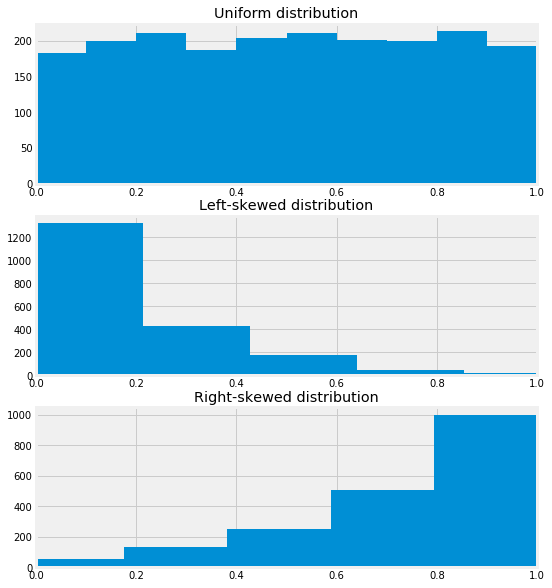

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(8)

# first subplot
axes[0].hist(unif)
axes[0].set_title('Uniform distribution')
axes[0].set_xlim(0, 1)

# second subplot
axes[1].hist(skewed_left)
axes[1].set_title('Left-skewed distribution')
axes[1].set_xlim(0, 1)

# third subplot
axes[2].hist(skewed_right)
axes[2].set_title('Right-skewed distribution')
axes[2].set_xlim(0, 1)

In [4]:
def qqplot(empirical_dist, legend = ""):
    """
    Generates two qq-plots one in the original scale of the data and 
    one using a negative log transformation to make the difference 
    between the expected and actual behavior more visible.
    
    If the observed line is outside the grey region denoted by the error bars,
    then it is quite unlikely that our data came from a Unif[0, 1] distribution.
    """
    x, y = probplot(empirical_dist, dist=stats.distributions.uniform(), fit=False)
    plt.scatter(x, y, c='r', alpha=1, )
    plt.xlabel("")
    plt.ylabel("")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Empirical Quantiles")
    plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), "--", label='x=y')
    plt.legend()
    plt.show()
    fastlmm_qqplot(empirical_dist, legend=legend, xlim=(0,3.6), ylim=(0,3.6), fixaxes=False)

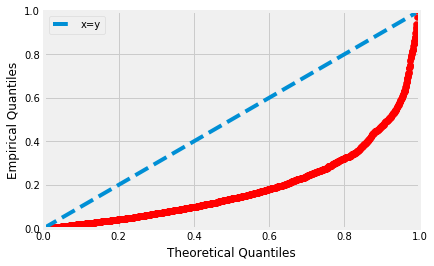

[3.6020599913279625, 3.1249387366082999, 2.9030899869919438, 2.7569619513137056, 2.6478174818886377, 2.5606673061697376, 2.4881166390211256, 2.4259687322722812, 2.3716110699496884, 2.3233063903751336, 2.279840696594043, 2.2403321553103694, 2.2041199826559246, 2.1706962271689751, 2.1396619934290064, 2.1106982974936899, 2.083546051450075, 2.0579919469776868, 2.0338582672609675, 2.010995384301463, 1.9892761346082268, 1.9685915357483759, 1.9488474775526188, 1.929962133392245, 1.9118639112994487, 1.894489815230026, 1.8777841217271733, 1.8616973018337186, 1.846185135655471, 1.8312079796858183, 1.8167301563171954, 1.8027194418743806, 1.7891466346851068, 1.7759851886271358, 1.7632109005907071, 1.750801642608887, 1.7387371312075066, 1.7269987279362624, 1.7155692661554804, 1.7044329000375209, 1.6935749724493125, 1.6829818989518885, 1.6726410656136697, 1.6625407387093438, 1.6526699846830497, 1.6430185990068689, 1.6335770427740273, 1.6243363860391147, 1.6152882570617175, 1.6064247967304124, 1.5977

/anaconda3/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


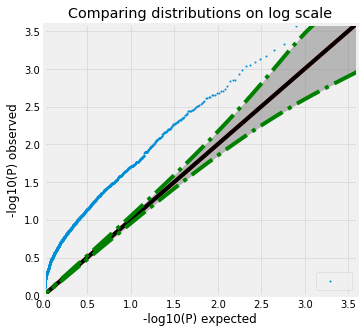

In [5]:
# SOLUTION CELL
qqplot(skewed_left)

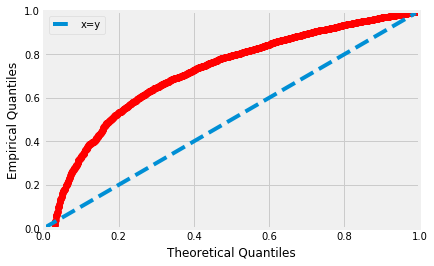

[3.6020599913279625, 3.1249387366082999, 2.9030899869919438, 2.7569619513137056, 2.6478174818886377, 2.5606673061697376, 2.4881166390211256, 2.4259687322722812, 2.3716110699496884, 2.3233063903751336, 2.279840696594043, 2.2403321553103694, 2.2041199826559246, 2.1706962271689751, 2.1396619934290064, 2.1106982974936899, 2.083546051450075, 2.0579919469776868, 2.0338582672609675, 2.010995384301463, 1.9892761346082268, 1.9685915357483759, 1.9488474775526188, 1.929962133392245, 1.9118639112994487, 1.894489815230026, 1.8777841217271733, 1.8616973018337186, 1.846185135655471, 1.8312079796858183, 1.8167301563171954, 1.8027194418743806, 1.7891466346851068, 1.7759851886271358, 1.7632109005907071, 1.750801642608887, 1.7387371312075066, 1.7269987279362624, 1.7155692661554804, 1.7044329000375209, 1.6935749724493125, 1.6829818989518885, 1.6726410656136697, 1.6625407387093438, 1.6526699846830497, 1.6430185990068689, 1.6335770427740273, 1.6243363860391147, 1.6152882570617175, 1.6064247967304124, 1.5977

/anaconda3/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


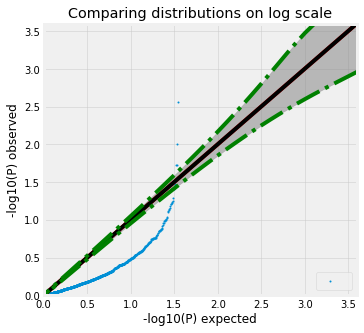

In [6]:
# SOLUTION CELL
qqplot(skewed_right)

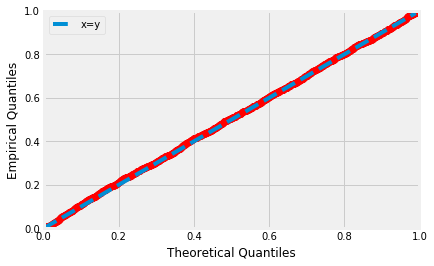

[3.6020599913279625, 3.1249387366082999, 2.9030899869919438, 2.7569619513137056, 2.6478174818886377, 2.5606673061697376, 2.4881166390211256, 2.4259687322722812, 2.3716110699496884, 2.3233063903751336, 2.279840696594043, 2.2403321553103694, 2.2041199826559246, 2.1706962271689751, 2.1396619934290064, 2.1106982974936899, 2.083546051450075, 2.0579919469776868, 2.0338582672609675, 2.010995384301463, 1.9892761346082268, 1.9685915357483759, 1.9488474775526188, 1.929962133392245, 1.9118639112994487, 1.894489815230026, 1.8777841217271733, 1.8616973018337186, 1.846185135655471, 1.8312079796858183, 1.8167301563171954, 1.8027194418743806, 1.7891466346851068, 1.7759851886271358, 1.7632109005907071, 1.750801642608887, 1.7387371312075066, 1.7269987279362624, 1.7155692661554804, 1.7044329000375209, 1.6935749724493125, 1.6829818989518885, 1.6726410656136697, 1.6625407387093438, 1.6526699846830497, 1.6430185990068689, 1.6335770427740273, 1.6243363860391147, 1.6152882570617175, 1.6064247967304124, 1.5977

/anaconda3/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


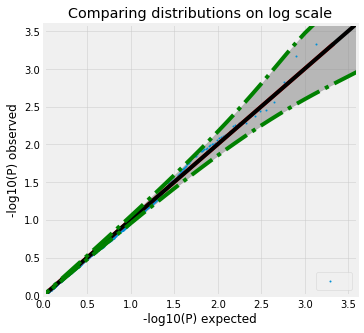

In [7]:
# SOLUTION CELL
qqplot(unif)

### Part b

We will use linear models in the genetic marker we are testing. In particular, when testing the $j^{\text{th}}$ genetic feature, we have that the trait, $\vec{y}$, is a linear function of the genetic variant, i.e. $ \vec{y} = \vec{x_j} w_1 + \vec{w_0} + \vec{\epsilon}$ where each entry $\epsilon_i$ of $\epsilon$ is random noise distributed as $N(0, \sigma^2)$, $w_1 \in \mathbb{R}^{1}$, $\vec{w_0}$ $\in \mathbb{R}^{n \times 1}$ is a constant vector, and $\vec{x_j}$ is the jth column of $X$, representing data for the jth genetic variant. To simplify matters, we will add a column of ones to the right end of $\vec{x_j}$ and rewrite the regression as $\vec{y}=[\vec{x_j}, \vec{1}] \vec{w} + \vec{\epsilon}$ where $[\vec{x_j}, \vec{1}]$ is the jth column of $X$ with a vector of ones appended to the end and $\vec{w} \in \mathbb{R}^{2 \times 1}$. The model without any genetic information, $\vec{y} = \vec{1}w + \vec{\epsilon}$ is referred to as the **null model** in the parlance of statistical testing. The **alternative model**, which includes the information we are testing (one genetic marker) is $\vec{y} = [\vec{x_j}, \vec{1}] \vec{w} + \vec{\epsilon}$ where $\vec{x_j}$ is the $j$th column of X, i.e. the data using only the $j$th genetic variant as a feature. **Plot the quantile-quantile plot of p-values using linear regression as just described, a so-called naive approach, by running the function** $naive\_model$. **From the plot, what do you conclude about the suitability of linear regression for this problem?**

In [8]:
# import all the data
X = load_X()
y=load_y()

#Normalize the columns
X = preprocessing.normalize(X, norm='l2', axis = 0)
y = y.reshape(-1, 1)
ones = np.ones(y.shape)
ones=ones.reshape(-1, 1)

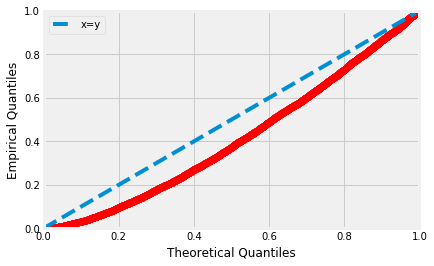

[4.1806419027298318, 3.7035206480101697, 3.4816718983938131, 3.3355438627155753, 3.2263993932905071, 3.1392492175716069, 3.0666985504229953, 3.0045506436741509, 2.9501929813515582, 2.901888301777003, 2.8584226079959127, 2.8189140667122392, 2.7827018940577943, 2.7492781385708449, 2.7182439048308762, 2.6892802088955596, 2.6621279628519448, 2.6365738583795566, 2.6124401786628368, 2.5895772957033327, 2.5678580460100964, 2.5471734471502456, 2.5274293889544883, 2.5085440447941147, 2.4904458227013184, 2.4730717266318956, 2.4563660331290431, 2.4402792132355882, 2.4247670470573408, 2.409789891087688, 2.3953120677190651, 2.3813013532762501, 2.3677285460869766, 2.3545671000290054, 2.3417928119925766, 2.3293835540107568, 2.3173190426093764, 2.3055806393381322, 2.29415117755735, 2.2830148114393904, 2.2721568838511823, 2.2615638103537581, 2.2512229770155394, 2.2411226501112136, 2.2312518960849195, 2.2216005104087384, 2.212158954175897, 2.2029182974409842, 2.1938701684635871, 2.1850067081322821, 2.17

/anaconda3/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


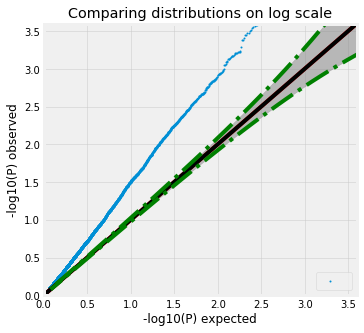

In [9]:
# SOLUTION CELL
# Note that the function naive_model returns the empirical distribution of p-values computed by the naive model
# Green lines indicate error bars.
naive_pvals = naive_model(X,y)
plt.show()
qqplot(naive_pvals)

Based on the previous plots, we see that the model tells us that there are more genetic markers that are informative in predicting trait $y$ than we would expect. Let's examine to what extent this is merely an artifact of the noise in our dataset not being iid using a correlation matrix. A correlation matrix visualizes the correlations between all datapoints in our dataset. If we can observe large correlations in the off-diagonal entries, then this presents strong evidence that our noise might not be iid.

Text(0.5,1,'What we should see if our data were IID')

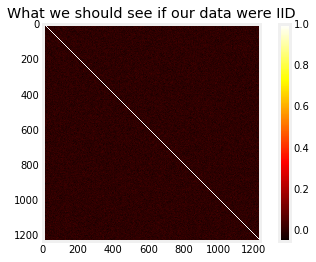

In [10]:
# If our data were iid we would expect to see a correlation matrix to look something like this
X_r = np.random.randn(X.shape[0], X.shape[1])

corr_matrix = np.corrcoef(X_r)
plt.grid(False)
plt.imshow(corr_matrix, "hot")
plt.colorbar()
plt.title("What we should see if our data were IID")

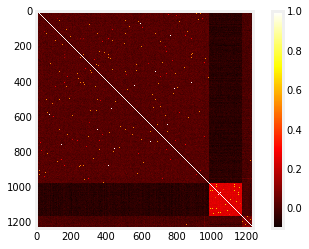

In [11]:
# Now let's see what we observe in our plot

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

def get_projection(X,k):
    _, _, V = np.linalg.svd(X)    
    V = V.T
    return V[:, :k]

def corr_matrix_data(X):
    # demean the data
    X_demeaned = X - np.mean(X, 0) 
    
    # get the projection matrix
    proj_matrix = get_projection(X_demeaned, 3)
    
    # get projected data
    X_proj = X_demeaned @ proj_matrix
    
    # do some k-means clustering to identify which points are in which cluster
    km = KMeans(n_clusters = 3)
    clusters = km.fit_predict(X_proj)
    
    # sort data based on identified clusters 
    t = pd.DataFrame(X)
    t['cluster'] = clusters
    t = t.sort_values("cluster")
    t = t.drop("cluster", 1)
    plt.imshow(np.corrcoef(t.as_matrix()), "hot")
    plt.colorbar()
    plt.grid(False)

corr_matrix_data(X)

By reorganizing the correlation matrix a bit, we can see that our data very much contains approximately 3 clusters, so in fact our iid noise assumptions certainly do not hold. At this point it might be a good idea to start considering projecting our data in a lower dimensional space, so that we can learn more about this dependency. 

Text(0,0.5,'PC2')

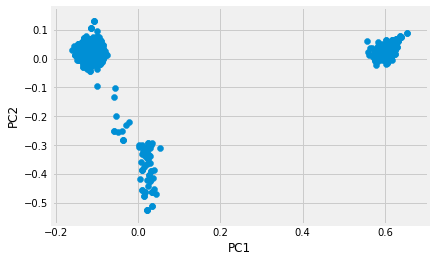

In [12]:
# Let's project our data in 2 dimensions
X_demeaned = X - np.mean(X, 0)
proj_matrix_2d = get_projection(X_demeaned, 2)
X_proj2d = X_demeaned @ proj_matrix_2d
plt.scatter(X_proj2d[:, 0], X_proj2d[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")

OR

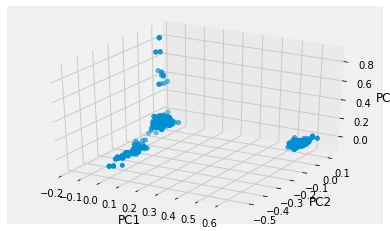

In [13]:
# Now let's project on 3 dimensions
from mpl_toolkits.mplot3d import Axes3D

proj_matrix_3d = get_projection(X_demeaned, 3)
X_proj3d = X_demeaned @ proj_matrix_3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = X_proj3d[:, 0]
ys = X_proj3d[:, 1]
zs = X_proj3d[:, 2]

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.scatter(xs, ys, zs)

In the visualizations above, see that there is certainly some underlying structure in our data. In fact, the clusters we observe are related to the ethnicities of people in our dataset! 

### Part c

From the quantile-quantile plot in the previous part, it appears that the model is picking up on more association than theoretically expected. The reason for this is owing to the assumption of iid noise being correct. In particular, this data set contains individuals from different racial backgrounds, and also has clusters of individuals from extended families (e.g. grandparents, parents, siblings). This means that their genetics are not iid, and hence linear regression yields spurious results--all the genetic features seem to be implicated in the trait. Thus we need to modify our noise assumptions by somehow accounting for the hidden structure in the data set. The main idea is that when testing one genetic feature, all the other genetic features, jointly, are a proxy to the racial and family background. If we could include them in our model, we could correct the problem. **Ideally we would like to use all the genetic features in the linear regression model, however this is not a good idea. Why not?** Hint: There are roughly 1300 individuals and 7500 genetic variants. A written, English answer is sufficient.
	
So instead of using all genetic features, we will try using PCA to reduce the number of genetic features. As we saw in class, PCA on a genetic similarity matrix can capture geography, which correlates to race, quite well. So instead of adding all the genetic features, we will instead use only three features (One needs to choose this number, but we have done so for you.), $X_{proj}$, which are the $X$ projected onto the top 3 principal components of $X$. Consequently, the updated null model is  $\vec{y} = X_{proj} \vec{w_{proj}} + \vec{\epsilon}$ where $\vec{w_{proj}} \in \mathbb{R}^{3 \times 1}$, while the alternative model is $\vec{y} = [\vec{x_j}, X_{proj}, \vec{1}] \vec{w} + \vec{\epsilon}$ where $\vec{w} \in \mathbb{R}^{5 \times 1}$ for genetic variant j.
**Plot the quantile-quantile plot from obtaining p-values with this PCA linear regression approach by running the function** $pca\_corrected\_model$.
**How does this plot compare to the first plot? What does this tell you about this model compared to the previous model?**

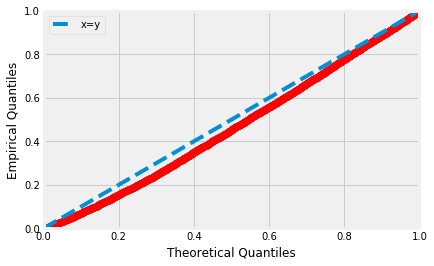

[4.1806419027298318, 3.7035206480101697, 3.4816718983938131, 3.3355438627155753, 3.2263993932905071, 3.1392492175716069, 3.0666985504229953, 3.0045506436741509, 2.9501929813515582, 2.901888301777003, 2.8584226079959127, 2.8189140667122392, 2.7827018940577943, 2.7492781385708449, 2.7182439048308762, 2.6892802088955596, 2.6621279628519448, 2.6365738583795566, 2.6124401786628368, 2.5895772957033327, 2.5678580460100964, 2.5471734471502456, 2.5274293889544883, 2.5085440447941147, 2.4904458227013184, 2.4730717266318956, 2.4563660331290431, 2.4402792132355882, 2.4247670470573408, 2.409789891087688, 2.3953120677190651, 2.3813013532762501, 2.3677285460869766, 2.3545671000290054, 2.3417928119925766, 2.3293835540107568, 2.3173190426093764, 2.3055806393381322, 2.29415117755735, 2.2830148114393904, 2.2721568838511823, 2.2615638103537581, 2.2512229770155394, 2.2411226501112136, 2.2312518960849195, 2.2216005104087384, 2.212158954175897, 2.2029182974409842, 2.1938701684635871, 2.1850067081322821, 2.17

/anaconda3/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


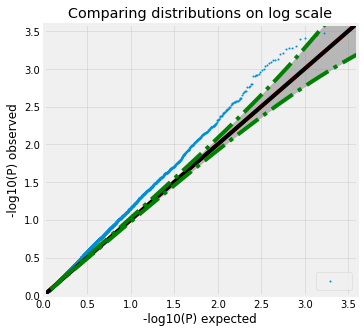

In [14]:

"""
remember that the function pca_corrected_model returns the 
empirical distribution of the p-values for the pca-corrected model
"""


pca_model_pvals = pca_corrected_model(X, y)
qqplot(pca_model_pvals)

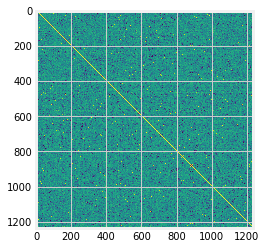

In [15]:
# Now, let's see if there is any patterns in our correlation matrix after we have removed the 
# 3 largest directions of variance identified by our PCA
X_new = X - X_proj3d  @ proj_matrix_3d.T
# change the scale a bit so that patterns are more clearly visible
corr_matrix = abs(np.corrcoef(X_new))
plt.imshow(np.log(corr_matrix+0.0001))

We observe that there are still some patterns that appear in our correlation matrix. That seems like evidence that we haven't captured the full extent of the relationship between our datapoints so far. Can we do better?

### Part d

PCA got us part of the way there. However, PCA truncates the eigenspectrum; if the tail-end of that spectrum is important, as it is for family-relatedness, then it will not fully correct for our problem. So we want a method which (a) is well-behaved in terms of number of parameters that need to be estimated, and (b) includes all of the information we need. So rather than adding the projections as features, we use an modelling approach called linear mixed models which effectively adjust the iid noise in the gaussian by the pairwise genetic similarity of all the individuals. That is, we set $\Sigma$ in $\vec{y} \sim N(y|[\vec{x_j}, 1] \vec{w}, I \sigma^2 + XX^\top \sigma^2_k)$.
	
Specifically, $\vec{y} = [\vec{x_j}, 1] \vec{w} + \vec{z} + \vec{\epsilon}$ where $\vec{z} \sim N(0, \sigma_k^2K)$ where $K = XX^\top$, $\sigma_k$,  $\vec{w} \in \mathbb{R}^{m \times 1}$, and $\sigma$ are parameters we want to estimate. Notice that $\vec{y} \sim N([\vec{x_j}, 1] \vec{w}, \sigma^2I + \sigma_k^2K)$. Evaluation of the likelihood is thus on the order of $O(n^3)$ from the required matrix inverse and determinant of $\sigma^2I + \sigma_k^2K$. To test $m$ genetic variants, the time complexity becomes $O(mn^3)$, which is extremely slow for large datasets. **Given the eigen-decomposition $K = UDU^\top$, how can we make this faster if we have to test thousands of genetic feature? Would this be computationally more efficient if you only have one genetic feature to test?**

**Finally, make the quantile-quantile plot for this last model by running the function** $\verb|lmm|$**. What can we conclude about this model relative to the other two models?**
	
_HINT: Since the manipulations needed for $\sigma^2I + \sigma_k^2K$ is the bottleneck here, we would like a transformation which makes this covariance of the multi-variate gaussian be a diagonal matrix._

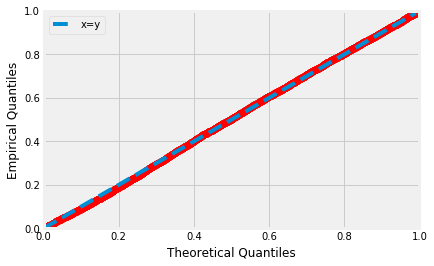

[4.1806419027298318, 3.7035206480101697, 3.4816718983938131, 3.3355438627155753, 3.2263993932905071, 3.1392492175716069, 3.0666985504229953, 3.0045506436741509, 2.9501929813515582, 2.901888301777003, 2.8584226079959127, 2.8189140667122392, 2.7827018940577943, 2.7492781385708449, 2.7182439048308762, 2.6892802088955596, 2.6621279628519448, 2.6365738583795566, 2.6124401786628368, 2.5895772957033327, 2.5678580460100964, 2.5471734471502456, 2.5274293889544883, 2.5085440447941147, 2.4904458227013184, 2.4730717266318956, 2.4563660331290431, 2.4402792132355882, 2.4247670470573408, 2.409789891087688, 2.3953120677190651, 2.3813013532762501, 2.3677285460869766, 2.3545671000290054, 2.3417928119925766, 2.3293835540107568, 2.3173190426093764, 2.3055806393381322, 2.29415117755735, 2.2830148114393904, 2.2721568838511823, 2.2615638103537581, 2.2512229770155394, 2.2411226501112136, 2.2312518960849195, 2.2216005104087384, 2.212158954175897, 2.2029182974409842, 2.1938701684635871, 2.1850067081322821, 2.17

/anaconda3/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


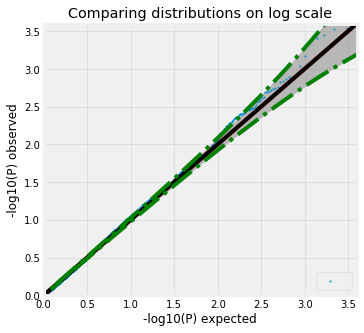

In [16]:
# SOLUTION CELL
lmm_pvals = lmm()
qqplot(lmm_pvals)